# Timon Spichtinger Machine Learning 2 Modularbeit

In [1]:
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import importlib
from Datensatz import get_emnist_test_train, show_random_samples
import torch.nn as nn

## 1.1 Datensatz

Train und Testdaten werden aus Emnist-Datensatz geladen. Falls es zuwenige gibt werden die restlichen Augmentiert

In [2]:
X_train, y_train, X_test, y_test,class_list = get_emnist_test_train()

Ziel-ASCII: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
Anzahl Zielklassen: 36
⚠️ Klasse B: nur 3878 echte Bilder – augmentiere 2122 zusätzlich.
⚠️ Klasse D: nur 4562 echte Bilder – augmentiere 1438 zusätzlich.
⚠️ Klasse E: nur 4934 echte Bilder – augmentiere 1066 zusätzlich.
⚠️ Klasse G: nur 2517 echte Bilder – augmentiere 3483 zusätzlich.
⚠️ Klasse H: nur 3152 echte Bilder – augmentiere 2848 zusätzlich.
⚠️ Klasse J: nur 3762 echte Bilder – augmentiere 2238 zusätzlich.
⚠️ Klasse K: nur 2468 echte Bilder – augmentiere 3532 zusätzlich.
⚠️ Klasse L: nur 5076 echte Bilder – augmentiere 924 zusätzlich.
⚠️ Klasse b: nur 5159 echte Bilder – augmentiere 841 zusätzlich.
⚠️ Klasse c: nur 2854 echte Bilder – augmentiere 3146 zusätzlich.
⚠️ Klasse f: nur 2561 echte Bilder – augmentiere 3439 zusätzlich.
⚠️ Klasse g: nur 3687 echte Bilder – augmentiere 2313 zusätzlich.
⚠️ Klasse i: nur 272

Stichprobe, ob der Datensatz passt

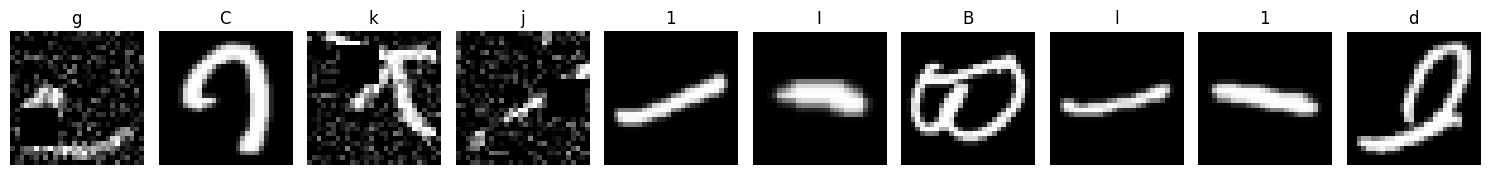

In [ ]:

show_random_samples(X_test, y_test, class_list, n=10)

In [3]:


import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import optuna
from Klassifikator import get_objective, ResNet18, EarlyStopping


/mnt/c/Users/Timon/Desktop/semester6/ml2/Modularbeit/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Gerät
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)



In [ ]:
# -----------------------------
# Optuna-Studie starten
# -----------------------------
study = optuna.create_study(direction="maximize")
study.optimize(get_objective(
          train_dataset=train_dataset,
          test_dataset=test_dataset,
          device=device,
          model=ResNet18(num_classes=len(class_list)).to(device),
          early_stopping=EarlyStopping()), n_trials=20)

# Beste Parameter anzeigen
print("🎯 Beste Hyperparameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")



[I 2025-06-25 10:15:32,113] A new study created in memory with name: no-name-b53304b0-b7d6-4fb9-8207-c8376a527d9d


TypeError: get_objective() got an unexpected keyword argument 'early_stopping'

In [ ]:
# -----------------------------
# Parameter fü Finales Training 
# -----------------------------
best_params = study.best_params
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

model = ResNet18(num_classes=len(class_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params["lr"], momentum=best_params["momentum"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"])





NameError: name 'study' is not defined

In [ ]:
def _1_2training(train_loader,test_loader,model,scheduler,epochs = 30):

    for epoch in range(30):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 200 == 0:
                print(f"🔁 Epoch {epoch+1}, Step {i+1}/{len(train_loader)}: Batch Loss = {loss.item():.4f}")

        scheduler.step()

        # Validierung
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_loss /= len(test_loader)
        train_acc = 100.0 * correct_train / total_train
        val_acc = 100.0 * correct_val / total_val

        print(f"📊 Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, Val Loss = {val_loss:.4f}, LR = {scheduler.get_last_lr()}")
        early_stopping = EarlyStopping()
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"🛑 Early stopping ausgelöst bei Epoch {epoch+1} (Val Loss: {val_loss:.4f})")
            break

_1_2training(train_loader,test_loader,model,scheduler,epochs = 30)


NameError: name 'train_loader' is not defined

In [ ]:
# Modell speichern
torch.save(model.state_dict(), './resnet18_best_hyperparams.pth')
print("✅ Modell gespeichert.")

In [ ]:
import torch
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def evaluate_model(model, test_loader, device, class_list):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Keine Gradientenberechnung, da wir nur evaluieren
        n_correct = 0
        n_samples = 0
        n_class_correct = defaultdict(int)
        n_class_samples = defaultdict(int)

        # Iteriere über den Testdatensatz
        for images, labels in test_loader:
            images = images.to(device)  # Bilder auf das gleiche Gerät verschieben (GPU oder CPU)
            labels = labels.to(device)  # Labels auf das gleiche Gerät verschieben (GPU oder CPU)
            
            # Vorwärtsdurchlauf
            outputs = model(images)
            
            # Vorhersagen
            _, predicted = torch.max(outputs, 1)

            # Update der Gesamtmetriken
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Update der Metriken pro Klasse
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

            # Speichere alle Labels und Vorhersagen für die Berechnung der weiteren Metriken
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Berechnung der Gesamtgenauigkeit
        acc = 100.0 * n_correct / n_samples
        print(f'Gesamtgenauigkeit des Netzwerks: {acc:.2f} %')

        # Berechnung der Klasse-genauen Genauigkeit
        for label in sorted(n_class_samples.keys()):
            ascii_char = class_list[label]
            class_acc = 100.0 * n_class_correct[label] / n_class_samples[label]
            print(f'Genauigkeit für Klasse {ascii_char}: {class_acc:.2f} %')

        # Berechnung der Precision, Recall und F1-Score für jede Klasse
        precision = precision_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        recall = recall_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        f1 = f1_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        
        # Berechne den durchschnittlichen F1-Score
        avg_f1 = f1_score(all_labels, all_predictions, average='weighted')
        
        print("\nPrecision, Recall, F1-Score pro Klasse:")
        for i, ascii_char in enumerate(class_list):
            print(f"Klasse {ascii_char}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1[i]:.2f}")
        
        print(f"\nDurchschnittlicher F1-Score (gewichtet): {avg_f1:.2f}")

        # Berechnung der Konfusionsmatrix
        cm = confusion_matrix(all_labels, all_predictions)
        print(f"\nKonfusionsmatrix:\n{cm}")

        # Berechnung der ROC-AUC (für Multiklassen kann man dies auch für jedes Label einzeln berechnen)
        try:
            roc_auc = roc_auc_score(all_labels, model_output_to_probs(model, test_loader, device), multi_class='ovr', average='weighted')
            print(f"\nDurchschnittliche ROC-AUC: {roc_auc:.2f}")
        except ValueError:
            print("\nROC-AUC konnte nicht berechnet werden (möglicherweise nicht geeignet für das Problem).")

        return acc

# Hilfsfunktion zur Berechnung der ROC-AUC für das Multiklassenproblem
def model_output_to_probs(model, test_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_probs)

# Beispielaufruf
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Wähle GPU, wenn verfügbar

# Modell auf das Gerät (GPU/CPU) verschieben
model = model.to(device)

# Jetzt den Evaluierungscode aufrufen
evaluate_model(model, test_loader, device, class_list)


Gesamtgenauigkeit des Netzwerks: 83.92 %
Genauigkeit für Klasse 0: 97.90 %
Genauigkeit für Klasse 1: 71.70 %
Genauigkeit für Klasse 2: 98.20 %
Genauigkeit für Klasse 3: 98.20 %
Genauigkeit für Klasse 4: 97.00 %
Genauigkeit für Klasse 5: 98.40 %
Genauigkeit für Klasse 6: 93.80 %
Genauigkeit für Klasse 7: 98.80 %
Genauigkeit für Klasse 8: 97.80 %
Genauigkeit für Klasse 9: 93.50 %
Genauigkeit für Klasse A: 98.40 %
Genauigkeit für Klasse B: 91.20 %
Genauigkeit für Klasse C: 91.60 %
Genauigkeit für Klasse D: 90.10 %
Genauigkeit für Klasse E: 93.90 %
Genauigkeit für Klasse F: 87.40 %
Genauigkeit für Klasse G: 89.50 %
Genauigkeit für Klasse H: 94.50 %
Genauigkeit für Klasse I: 52.10 %
Genauigkeit für Klasse J: 82.30 %
Genauigkeit für Klasse K: 78.40 %
Genauigkeit für Klasse L: 93.30 %
Genauigkeit für Klasse M: 58.20 %
Genauigkeit für Klasse a: 94.50 %
Genauigkeit für Klasse b: 89.00 %
Genauigkeit für Klasse c: 53.90 %
Genauigkeit für Klasse d: 96.80 %
Genauigkeit für Klasse e: 97.20 %
Genauig

83.91944444444445

# 1.3

In [ ]:
def create_type_labeled_dataloaders(X_train, y_train, X_test, y_test, class_list, batch_size):
    def get_type_labels(y_tensor):
        type_labels = []
        for label in y_tensor:
            char = str(class_list[int(label)])  # Ensure it's a string
            
            if char.isdigit():
                type_labels.append(0)  # Ziffer
            elif char.isupper():
                type_labels.append(1)  # Großbuchstabe
            else:
                type_labels.append(2)  # Kleinbuchstabe
        return torch.tensor(type_labels, dtype=torch.long)

    y_train_type = get_type_labels(y_train)
    y_test_type = get_type_labels(y_test)

    train_dataset = TensorDataset(X_train, y_train, y_train_type)
    test_dataset = TensorDataset(X_test, y_test, y_test_type)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [ ]:
train_loader, test_loader = create_type_labeled_dataloaders(
    X_train, y_train, X_test, y_test,
    class_list=class_list,
    batch_size=best_params["batch_size"]
)


In [ ]:
def get_type_label_tensor(label_tensor):
    class_list = list('0123456789ABCDEFGHIJKLMabcdefghijklm')
    label_to_class = {i: c for i, c in enumerate(class_list)}
    
    type_labels = []
    for label in label_tensor:
        char = label_to_class[int(label)]
        if char.isdigit():
            type_labels.append(0)
        elif char.isupper():
            type_labels.append(1)
        else:
            type_labels.append(2)
    return torch.tensor(type_labels, dtype=torch.long)

In [ ]:
y_train_type = get_type_label_tensor(y_train)
y_test_type = get_type_label_tensor(y_test)


In [ ]:
train_dataset = TensorDataset(X_train, y_train, y_train_type)
test_dataset = TensorDataset(X_test, y_test, y_test_type)


In [ ]:
# Beispielhafte Klasse-zu-Typ-Zuordnung: 0 = Groß, 1 = Klein, 2 = Ziffer
def get_type_label_tensor(y):
    type_labels = []
    for label in y:
        char = class_list[label]
        if char.isdigit():
            type_labels.append(2)
        elif char.isupper():
            type_labels.append(0)
        else:
            type_labels.append(1)
    return torch.tensor(type_labels)

In [ ]:
class TypeClassifier(nn.Module):
    def __init__(self):
        super(TypeClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        return F.softmax(self.fc(x), dim=1)



In [ ]:
class ModularClassifier(nn.Module):
    def __init__(self, tm1, tm2, class_type_map):
        super(ModularClassifier, self).__init__()
        self.tm1 = tm1
        self.tm2 = tm2
        self.class_type_map = torch.tensor(class_type_map, dtype=torch.long)  # Länge 36

    def forward(self, x):
        out_cls = self.tm1(x)  # shape (B, 36)
        out_type = self.tm2(x)  # shape (B, 3)

        type_probs = out_type[:, self.class_type_map.to(x.device)]  # shape (B, 36)
        final_out = out_cls * type_probs  # Elementweise Multiplikation

        return final_out, out_cls, out_type


In [ ]:
# class_list = ['0', '1', ..., 'a', 'b', ...]
class_type_map = []
for c in class_list:
    if c.isdigit():
        class_type_map.append(2)
    elif c.isupper():
        class_type_map.append(0)
    else:
        class_type_map.append(1)



AttributeError: 'int' object has no attribute 'isdigit'

In [ ]:
tm1 = ResNet18(num_classes=len(class_list))

modular_model = ModularClassifier(
    tm1,
    tm2=TypeClassifier(),
    class_type_map=class_type_map
).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_type = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modular_model.parameters(), lr=1e-3)


In [ ]:
for epoch in range(30):
    modular_model.train()
    total_loss = 0.0  # ✅ richtig initialisieren

    for images, labels_cls, labels_type in train_loader:
        images = images.to(device)
        labels_cls = labels_cls.to(device)
        labels_type = labels_type.to(device)

        final_out, out_cls, out_type = modular_model(images)

        loss_cls = criterion_cls(out_cls, labels_cls)
        loss_type = criterion_type(out_type, labels_type)
        loss = loss_cls + 0.5 * loss_type

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # ✅ jetzt ist total_loss eine float

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")




RuntimeError: The size of tensor a (36) must match the size of tensor b (0) at non-singleton dimension 1

[]

'4'